In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import torch
import re
import unicodedata
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

/kaggle/input/ys19-2023-assignment-4a/sample_submission.csv
/kaggle/input/ys19-2023-assignment-4a/test_set.csv
/kaggle/input/ys19-2023-assignment-4a/valid_set.csv
/kaggle/input/ys19-2023-assignment-4a/train_set.csv


# Initial Clean of the Data

In [2]:
def remove_urls(text):
    text = re.sub(r'http\S+|www\S+|https\S', '', text)
    return text

def remove_hashtags_mentions(text):
    hashtags = re.findall(r'\#\w+', text)
    for hashtag in hashtags:
        split_words = hashtag[1:].split('_')
        text = text.replace(hashtag, ' '.join(split_words))
    text = re.sub(r'\@\w+', '', text)
    return text

def remove_punctuations(text):
    text = re.sub(r'[.,!?:;/()|&]+', '', text)
    return text

def remove_special_characters(text):
    text = re.sub(r'[\"«»-]', '', text)
    return text

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

def preprocess_tweets(text):
    text = remove_urls(text)
    text = remove_hashtags_mentions(text)
    # text = remove_punctuations(text)
    text = remove_special_characters(text)
    return strip_accents_and_lowercase(text)

# Tokenization and Input Formatting

In [3]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
# tokenizer = AutoTokenizer.from_pretrained("EftychiaKarav/DistilGREEK-BERT")

label_encoder = LabelEncoder()

def tokenize_and_format(sentences, max_length=64):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Load, Tokenize and Dataloaders

# Train

In [4]:
# as chosen by Optuna's best trial
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 4

train_data = pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/train_set.csv')
train_data['Text'] = train_data['Text'].apply(preprocess_tweets)

train_input_ids, train_attention_masks = tokenize_and_format(train_data['Text'])
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)

train_labels = label_encoder.fit_transform(train_data['Sentiment'])
train_labels = torch.tensor(train_labels, dtype=torch.long)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)

# Validation

In [5]:
valid_data = pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/valid_set.csv')
valid_data['Text'] = valid_data['Text'].apply(preprocess_tweets)

valid_input_ids, valid_attention_masks = tokenize_and_format(valid_data['Text'])
valid_input_ids = torch.cat(valid_input_ids, dim=0)
valid_attention_masks = torch.cat(valid_attention_masks, dim=0)

valid_labels = label_encoder.fit_transform(valid_data['Sentiment'])
valid_labels = torch.tensor(valid_labels, dtype=torch.long)

valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
valid_dataloader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=BATCH_SIZE)

# GreekBERT Model

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", num_labels=len(label_encoder.classes_))
# model = AutoModelForSequenceClassification.from_pretrained("EftychiaKarav/DistilGREEK-BERT", num_labels=len(label_encoder.classes_))

if torch.cuda.is_available():    
    device = torch.device("cuda")
    model.cuda()
else:
    device = torch.device("cpu")


pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Optimizer - Learning Rate Scheduler

In [7]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training and Evaluation

In [8]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch_i in range(0, EPOCHS):
    # Training
    model.train()
    total_train_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch and move tensors to the device
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # training accuracy
        _, predicted_labels = torch.max(logits, dim=1)
        correct_preds += (predicted_labels == b_labels).cpu().float().sum()  # Move tensor to CPU
        total_preds += b_labels.size(0)

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_preds.cpu().numpy() / total_preds  # Move tensor to CPU before converting to NumPy
    train_losses.append(avg_train_loss)
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0

    for batch in valid_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            
        loss, logits = outputs.loss, outputs.logits
        total_val_loss += loss.item()

        # validation accuracy
        _, predicted_labels = torch.max(logits, dim=1)
        correct_val_preds += (predicted_labels == b_labels).cpu().float().sum()  # Move tensor to CPU
        total_val_preds += b_labels.size(0)

    avg_val_loss = total_val_loss / len(valid_dataloader)
    val_accuracy = correct_val_preds.cpu().numpy() / total_val_preds
    val_losses.append(avg_val_loss)
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch_i + 1}: Train loss: {avg_train_loss}, Train acc: {train_accuracy}, Val loss: {avg_val_loss}, Val acc: {val_accuracy}")


Epoch 1: Train loss: 1.09566250584011, Train acc: 0.36715806715806715, Val loss: 1.0685367595165147, Val acc: 0.4023318042813456
Epoch 2: Train loss: 1.0623502126166915, Train acc: 0.40717990717990715, Val loss: 1.0538529155815777, Val acc: 0.4115061162079511
Epoch 3: Train loss: 1.0301855473018628, Train acc: 0.43933933933933933, Val loss: 1.0581121309817019, Val acc: 0.41628440366972475
Epoch 4: Train loss: 0.9976733781104525, Train acc: 0.4726180726180726, Val loss: 1.0624028167228816, Val acc: 0.41628440366972475


# Classification Report

In [9]:
from sklearn.metrics import classification_report

def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            batch_preds = np.argmax(logits, axis=1)
            predictions.extend(batch_preds)
            true_labels.extend(label_ids)

    return predictions, true_labels

# training predictions
train_preds, train_true_labels = get_predictions(model, train_dataloader)
print("Training Classification Report")
print(classification_report(train_true_labels, train_preds, target_names=label_encoder.classes_))

# validation predictions
val_preds, val_true_labels = get_predictions(model, valid_dataloader)
print("Validation Classification Report")
print(classification_report(val_true_labels, val_preds, target_names=label_encoder.classes_))


Training Classification Report
              precision    recall  f1-score   support

    NEGATIVE       0.48      0.66      0.55     12210
     NEUTRAL       0.55      0.39      0.46     12210
    POSITIVE       0.55      0.49      0.52     12210

    accuracy                           0.51     36630
   macro avg       0.52      0.51      0.51     36630
weighted avg       0.52      0.51      0.51     36630

Validation Classification Report
              precision    recall  f1-score   support

    NEGATIVE       0.41      0.56      0.47      1744
     NEUTRAL       0.43      0.31      0.36      1744
    POSITIVE       0.42      0.38      0.40      1744

    accuracy                           0.42      5232
   macro avg       0.42      0.42      0.41      5232
weighted avg       0.42      0.42      0.41      5232



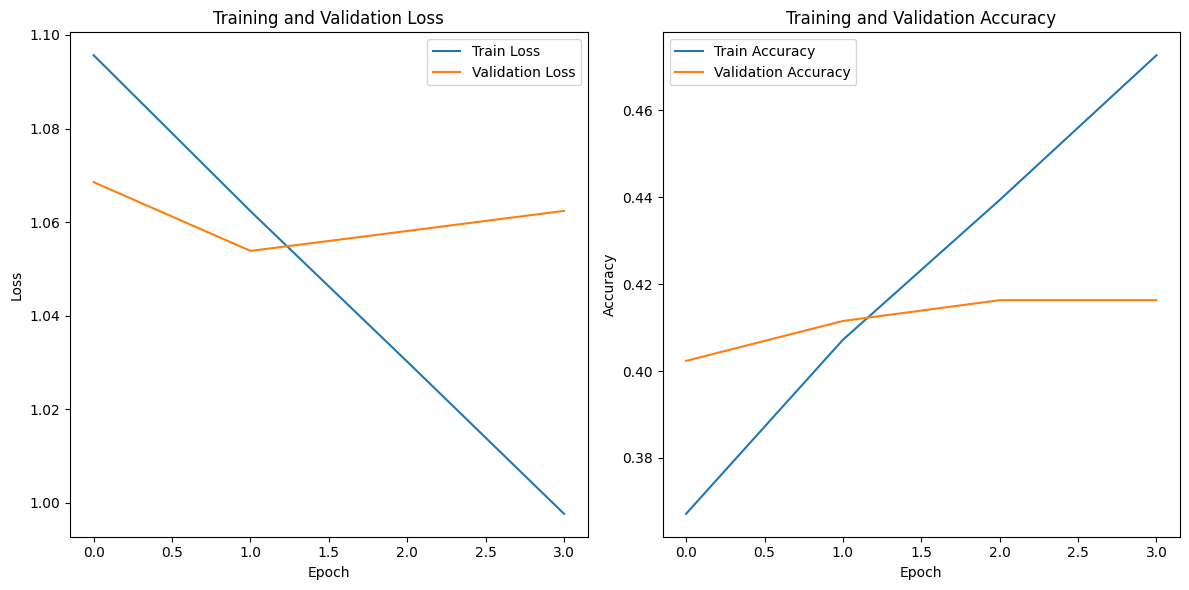

In [10]:
plt.figure(figsize=(12, 6))

# training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Test Dataset Predictions

In [11]:
test_data = pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/test_set.csv')
test_data['Text'] = test_data['Text'].apply(preprocess_tweets)

test_input_ids, test_attention_masks = tokenize_and_format(test_data['Text'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model.eval()
predictions = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

predictions = np.concatenate(predictions, axis=0)
predicted_labels = np.argmax(predictions, axis=1)

predicted_sentiment_labels = label_encoder.inverse_transform(predicted_labels)

submission_df = pd.DataFrame({'Id': range(1, len(test_data) + 1), 'Predicted': predicted_sentiment_labels})
submission_df.to_csv('Greek-BERT_submission.csv', index=False)

# Optuna's trials implementation

In [12]:
# import optuna
# from transformers import get_linear_schedule_with_warmup
# from tqdm import tqdm
# from torch.optim import AdamW

# def objective(trial):
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
#     num_epochs = trial.suggest_int('num_epochs', 2, 4)

#     # Training
#     train_data = pd.read_csv('ys19-2023-assignment-4/train_set.csv')
#     train_data['Text'] = train_data['Text'].apply(preprocess_tweets)

#     train_input_ids, train_attention_masks = tokenize_and_format(train_data['Text'])
#     train_input_ids = torch.cat(train_input_ids, dim=0)
#     train_attention_masks = torch.cat(train_attention_masks, dim=0)

#     train_labels = label_encoder.fit_transform(train_data['Sentiment'])
#     train_labels = torch.tensor(train_labels, dtype=torch.long)

#     train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
#     train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

#     # Validation
#     valid_data = pd.read_csv('ys19-2023-assignment-4/valid_set.csv')
#     valid_data['Text'] = valid_data['Text'].apply(preprocess_tweets)

#     valid_input_ids, valid_attention_masks = tokenize_and_format(valid_data['Text'])
#     valid_input_ids = torch.cat(valid_input_ids, dim=0)
#     valid_attention_masks = torch.cat(valid_attention_masks, dim=0)

#     valid_labels = label_encoder.fit_transform(valid_data['Sentiment'])
#     valid_labels = torch.tensor(valid_labels, dtype=torch.long)

#     valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
#     valid_dataloader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size)


#     model = AutoModelForSequenceClassification.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", num_labels=len(label_encoder.classes_))
    
#     if torch.cuda.is_available():    
#         device = torch.device("cuda")
#         model.cuda()
#     else:
#         device = torch.device("cpu")

#     optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
#     total_steps = len(train_dataloader) * num_epochs
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#     train_losses, val_losses = [], []
#     train_acc, val_acc = [], []

#     for epoch in range(0, num_epochs):
#         # Training
#         model.train()
#         total_train_loss = 0
#         correct_preds = 0
#         total_preds = 0

#         for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}, Training'):
#             # Unpack this training batch and move tensors to the device
#             b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
#             model.zero_grad()

#             outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#             loss, logits = outputs.loss, outputs.logits
#             total_train_loss += loss.item()
            
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             scheduler.step()

#             # training accuracy
#             _, predicted_labels = torch.max(logits, dim=1)
#             correct_preds += (predicted_labels == b_labels).cpu().float().sum()  # Move tensor to CPU
#             total_preds += b_labels.size(0)

#         avg_train_loss = total_train_loss / len(train_dataloader)
#         train_accuracy = correct_preds.cpu().numpy() / total_preds  # Move tensor to CPU before converting to NumPy
#         train_losses.append(avg_train_loss)
#         train_acc.append(train_accuracy)

#         # Validation
#         model.eval()
#         total_eval_accuracy = 0
#         for batch in tqdm(valid_dataloader, total=len(valid_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}, Validation'):
#             b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            
#             with torch.no_grad():
#                 outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                
#             logits = outputs.logits
#             logits = logits.detach().cpu().numpy()
#             label_ids = b_labels.to('cpu').numpy()

#             # accuracy for this batch of test sentences.
#             total_eval_accuracy += accuracy_score(label_ids, np.argmax(logits, axis=1))

#         # average accuracy over all batches
#         avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)

#         trial.report(avg_val_accuracy, epoch)

#         # Handle pruning based on the intermediate value.
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return avg_val_accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# print(study.best_trial)
